#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18B Forecasting a home price index**

using case-schiller-la dataset

version 1.0 2021-05-05

In [113]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from datetime import datetime
import sys
import statsmodels
import patsy
import pmdarima
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

In [114]:
path = Path(os.getcwd())

In [115]:
base_dir = path.parent.parent

In [116]:
data_in = os.path.join(str(base_dir), "da_data_repo/case-shiller-la/clean/")
data_out = os.path.join(str(base_dir), "da_data_repo/ch18-case-shiller-la/")
output = os.path.join(data_out, "output")
func = os.path.join(str(base_dir), "da_case_studies/ch00-tech-prep/")

In [117]:
sys.path.append(func)
from py_helper_functions import *

In [118]:
csv_path = os.path.join(data_in,"homeprices-data-2000-2018.csv")
data = pd.read_csv(csv_path)

In [119]:
data.head()

,date,year,month,ps,pn,us,un,emps,empn
0,2000-01-01,2000,1,101.031209,100.00000,5.0,5.4,14344.4,14132.8
1,2000-02-01,2000,2,102.043406,100.61896,5.0,5.3,14390.4,14270.0
2,2000-03-01,2000,3,103.224699,102.12780,5.0,5.3,14429.1,14421.3
3,2000-04-01,2000,4,104.159399,103.70410,5.0,4.7,14484.6,14450.8
4,2000-05-01,2000,5,104.924698,104.98908,5.0,4.7,14549.9,14590.2


In [120]:
data = data.assign(date=lambda x: x.date.str[0:7])

data = data.rename({"ps": "p", "us": "u", "emps": "emp"},axis=1)

In [121]:
data = data.sort_values(by=["date"]).assign(
    dp=lambda x: x.p.diff(1),
    p_lag=lambda x: x.p.shift(1),
    lnp=lambda x: np.log(x.p),
    dlnp=lambda x: x.lnp.diff(1),
    lnp_lag=lambda x: x.lnp.shift(1),
    dlnp_lag=lambda x: x.dlnp.shift(1),
    du=lambda x: x.u.diff(1),
    lnemp=lambda x: np.log(x.emp),
    dlnemp=lambda x: x.lnemp.diff(1),
    trend=lambda x: range(1, data.shape[0] + 1),
)

In [122]:
# now save the workfile with data from 2000 through 2018

data.to_pickle("case-shiller-workfile-2000-2018.pkl")

In [123]:
# and now create and save the workfile with data from 2000 through 2017

data = data.loc[lambda x: x.year <= 2017]
data.to_pickle("case-shiller-workfile-2000-2017.pkl")

In [124]:
# Figure 18.8

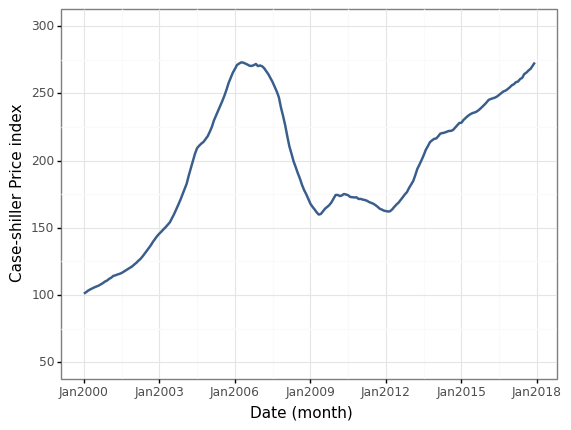

<ggplot: (325434122)>

In [125]:
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("1 year")

price_index_plot = (
    ggplot(data, aes(x="date", y="p", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[50, 300], breaks=seq(50, 301, 50))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Case-shiller Price index", x="Date (month)")
    + theme_bw()
)
price_index_plot

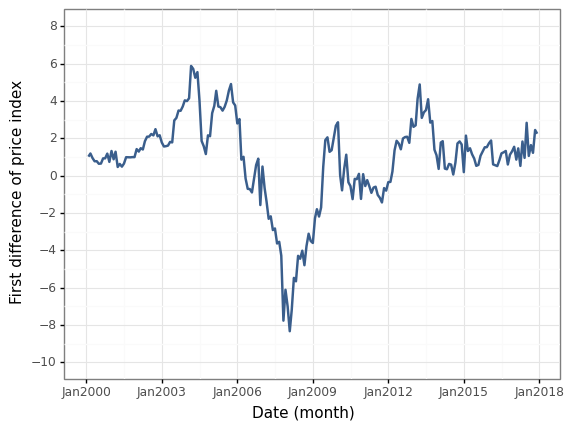

<ggplot: (324998084)>

In [126]:
# additional graphs, not in textbook
# Plot log difference of price index

dp_plot = (
    ggplot(data, aes(x="date", y="dp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-10, 8], breaks=seq(-10, 9, 2))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="First difference of price index", x="Date (month)")
    + theme_bw()
)
dp_plot

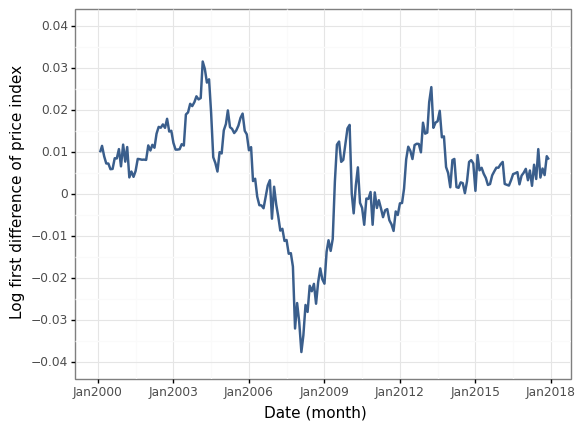

<ggplot: (325019932)>

In [127]:
# Plot log difference of price index
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("1 year")

dlnp_plot = (
    ggplot(data, aes(x="date", y="dlnp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-0.04, 0.04], breaks=seq(-0.04, 0.05, 0.01))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log first difference of price index", x="Date (month)")
    + theme_bw()
)
dlnp_plot

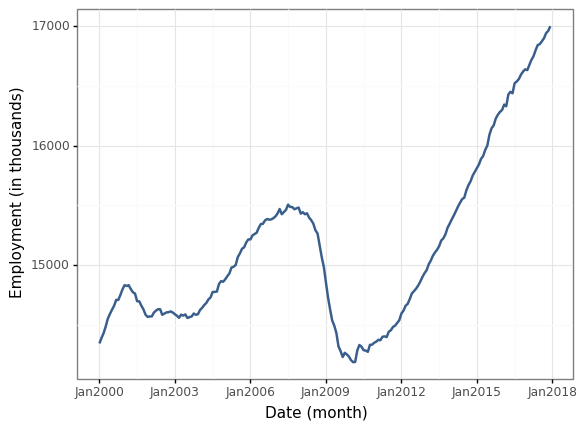

<ggplot: (325351039)>

In [128]:
## Figure 18.10

# additional graphs, not in textbook
# Plot log difference of price index

emp_plot = (
    ggplot(data, aes(x="date", y="emp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Employment (in thousands)", x="Date (month)")
    + theme_bw()
)
emp_plot

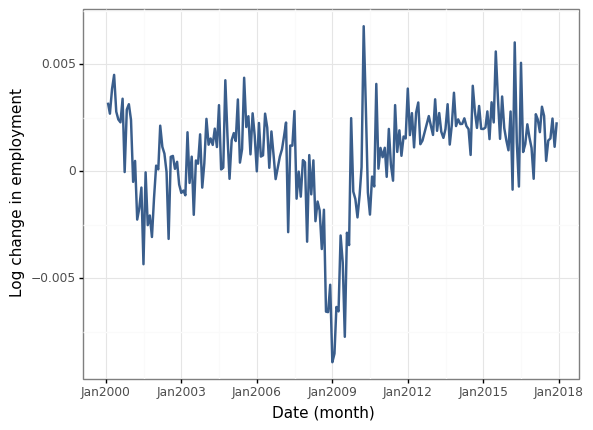

<ggplot: (325908718)>

In [129]:
# Plot log diff employment
lnemp_plot = (
    ggplot(data, aes(x="date", y="dlnemp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log change in employment", x="Date (month)")
    + theme_bw()
)

lnemp_plot

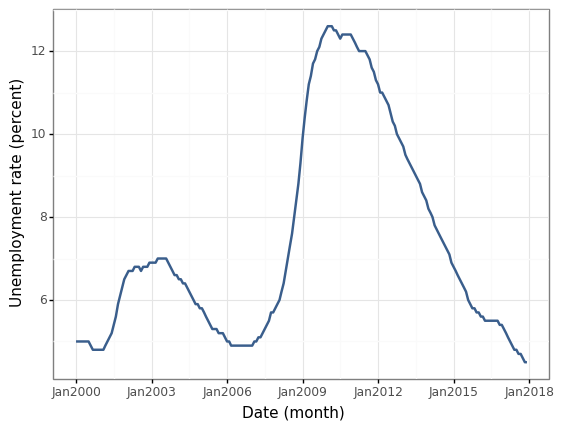

<ggplot: (325570907)>

In [130]:
# Plot unemployment rate
u_plot = (
    ggplot(data, aes(x="date", y="u", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Unemployment rate (percent)", x="Date (month)")
    + theme_bw()
)

u_plot

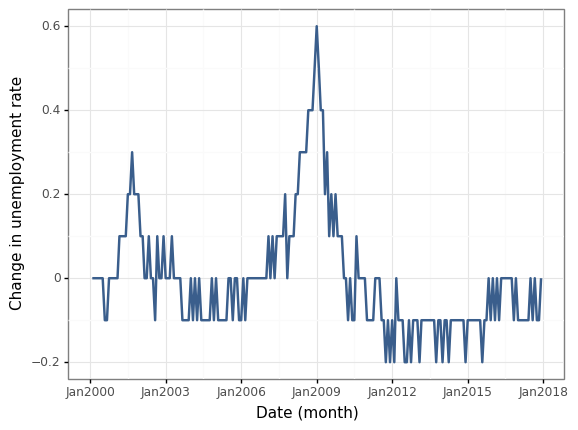

<ggplot: (325345380)>

In [131]:
# Plot diff unemployment

du_plot = (
    ggplot(data, aes(x="date", y="du", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Change in unemployment rate", x="Date (month)")
    + theme_bw()
)

du_plot

### Create work set and holdout set

In [138]:
data_holdout = data.loc[data["year"] == 2017, :]
data_train = data.loc[data["year"] < 2017, :]

In [139]:
# TODO:
# data seems ok but stat values don't match
# R kpss_stat=1.47
# R doc
# unitroot_kpss computes the statistic for the
# Kwiatkowski et al. unit root test with linear trend and lag 1.

statsmodels.tsa.stattools.kpss(data["p"], regression="ct", nlags=1)

(1.2024784171623186,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [140]:
# TODO:
# data seems ok but stat values don't match
# R kpss_stat=1.70
statsmodels.tsa.stattools.kpss(data["lnp"], regression="ct", nlags=1)

(1.3138981168558288,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [141]:
#create arima models in R

In [142]:
y, X = patsy.dmatrices("p ~ month", data_train)

In [143]:
#TODO:
#Problem auto-arima doesnt seem to fit the same model as in R. ?

In [144]:
arima=pmdarima.arima.auto_arima(y,X,with_intercept=True,seasonal=False)

In [145]:
arima

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [146]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:                        SARIMAX   Log Likelihood               -1082.344
Date:                Thu, 03 Jun 2021   AIC                           2170.688
Time:                        20:33:30   BIC                           2180.642
Sample:                             0   HQIC                          2174.714
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.0323      7.177     26.060      0.000     172.966     201.099
x1             0.7620      0.990      0.770      0.441      -1.178       2.702
sigma2      2377.3430    336.811      7.058      0.000    1717.206    3037.480
===================================================================================
Ljung-Box (L1) (Q):                 201.29   Jarque-Bera (JB):                 8.92
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.37   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         1.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#Setting pdq values as found by R ARIMA the values are pretty close

In [46]:
arima = pmdarima.arima.ARIMA(order=(2,1,1),
                             seasonal_order=(0,0,0,0),with_intercept=True)

In [49]:
res = arima.fit(y,X)

ValueError: A constant trend was included in the model specification, but the `exog` data already contains a column of constants.

In [48]:
res.summary()

NameError: name 'res' is not defined

In [104]:
y,X = patsy.dmatrices("dp ~ month",data_train)
arima=pmdarima.arima.auto_arima(y,X,with_intercept=True,seasonal=False)
arima

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [105]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -255.447
Date:                Wed, 13 Jan 2021   AIC                            538.895
Time:                        10:28:29   BIC                            585.280
Sample:                             0   HQIC                           557.660
                                - 203                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1818      1.134     -0.160      0.873      -2.405       2.041
x1             0.1833      0.161      1.136      0.256      -0.133       0.500
x2             1.1581      0.247      4.685      0.000       0.674       1.642
x3             2.0872      0.304      6.859      0.000       1.491       2.684
x4             2.3754      0.375      6.341      0.000       1.641       3.110
x5             2.2126      0.399      5.542      0.000       1.430       2.995
x6             1.8868      0.428      4.404      0.000       1.047       2.727
x7             1.3291      0.426      3.121      0.002       0.495       2.164
x8             0.9052      0.401      2.260      0.024       0.120       1.690
x9             0.3573      0.340      1.050      0.294      -0.309       1.024
x10            0.0357      0.277      0.129      0.897      -0.507       0.578
x11           -0.0623      0.201     -0.309      0.757      -0.457       0.332
ar.L1          0.9375      0.020     46.851      0.000       0.898       0.977
sigma2         0.7178      0.064     11.293      0.000       0.593       0.842
===================================================================================
Ljung-Box (Q):                       46.15   Jarque-Bera (JB):                48.21
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.67
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
reg1 = smf.ols('dlnp ~ dlnp_lag', data=data_train).fit()

In [109]:
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                   dlnp   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     839.7
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.63e-73
Time:                        10:33:45   Log-Likelihood:                 779.72
No. Observations:                 202   AIC:                            -1555.
Df Residuals:                     200   BIC:                            -1549.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      0.771      0.4

In [110]:
##Fit ARIMA type models